In [1]:
%%time
import numpy as np
import pandas as pd
import bz2
import warnings,os
from SentimentAnaylsisUtility import SentimentAnaylsisUtility
from ScoreVecClassifier import ScoreVecClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import confusion_matrix
from nltk.classify import ClassifierI
from statistics import mode
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import nltk
import random
import pickle
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
import ast
import json

warnings.filterwarnings('ignore')
utility = SentimentAnaylsisUtility()

Wall time: 11.5 s


<Figure size 1152x504 with 0 Axes>

In [2]:
%%time
trainfile = bz2.BZ2File('train.ft.txt.bz2','r')
lines = trainfile.readlines()

Wall time: 1min 45s


In [3]:
%%time
train_df = pd.DataFrame() 
docSentimentList=utility.getDocumentSentimentList(lines[:50000],splitStr='__label__')
train_df = pd.DataFrame(docSentimentList,columns=['Index','Text','Sentiment'])
train_df.set_index(['Index'])
train_df[["Sentiment"]] = train_df[["Sentiment"]].apply(pd.to_numeric)
train_df['Text'] = train_df['Text'].progress_apply(lambda x:utility.remove_URL(x))
train_df['Text'] = train_df['Text'].progress_apply(lambda x:utility.remove_html(x))
train_df['Text'] = train_df['Text'].progress_apply(lambda x:utility.fix_punctuation(x))
train_df['Pre_processed'] = train_df['Text'].progress_apply(lambda x:utility.spacy_pre_processing(x))


Wall time: 2min 5s


In [4]:
%%time
X_train, X_test, y_train, y_test = train_test_split(train_df['Pre_processed'], train_df['Sentiment'], test_size = 0.3, random_state=0, shuffle = True, stratify=train_df['Sentiment'])

pipe = make_pipeline(TfidfVectorizer(
                                    stop_words='english',
                                    strip_accents='unicode',
                                    token_pattern=r'\w{1,}',
                                    analyzer='word',
                                    ngram_range=(1, 1),
                                    min_df=5),
                     OneVsRestClassifier(LogisticRegression()))
param_grid = {'tfidfvectorizer__max_features': [10000, 30000]} 
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='roc_auc')
grid3 = grid.fit(X_train, y_train)
print(grid3.best_estimator_.named_steps['tfidfvectorizer'])

vectorizer = TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=np.float64, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=utility.STOP_WORDS, strip_accents='unicode',
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)
vectorizer.fit(X_train)
X_train_word_features = vectorizer.transform(X_train)
X_test_word_features = vectorizer.transform(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)
Wall time: 37.6 s


In [5]:
def getConfusionMatrixScore(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    sensitivity  = TP / (TP+FN)
    specificity  = TN / (TN+FP)
    pos_pred_val = TP/ (TP+FP)
    neg_pred_val = TN/ (TN+FN)
    return round(sensitivity,3),round(specificity,3),round(pos_pred_val,3),round(neg_pred_val,3)

In [6]:
%%time
class accuracy_dict(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value
        
    def get(self,key):
        return self[key]
    
scoringDF = pd.DataFrame(columns = ['Classifier', 'Accuracy', 'Precision','Recall','Fscore','Sensitivity','Specificity','Pos_pred_val','Neg_pred_val']) 
        
accuracy_dict = accuracy_dict() 
print("-------------------------------------------------------------------------")
print("RandomForestClassifier_classifier")
print("-------------------------------------------------------------------------")
RandomForestClassifier_classifier = ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
RandomForestClassifier_classifier.fit(X_train_word_features, y_train)
y_pred = RandomForestClassifier_classifier.predict(X_test_word_features)
print(classification_report(y_test, y_pred))
accuracy_dict.add(type(RandomForestClassifier_classifier).__name__,round(accuracy_score(y_test, y_pred, normalize=True),2))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(RandomForestClassifier_classifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 

print("-------------------------------------------------------------------------")
print("BernoulliNB_classifier")
print("-------------------------------------------------------------------------")
BernoulliNB_classifier = BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
BernoulliNB_classifier.fit(X_train_word_features, y_train)
y_pred = BernoulliNB_classifier.predict(X_test_word_features)
print(classification_report(y_test, y_pred))
accuracy_dict.add(type(BernoulliNB_classifier).__name__,round(accuracy_score(y_test, y_pred, normalize=True),2))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(BernoulliNB_classifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 


print("-------------------------------------------------------------------------")
print("SVC_classifier")
print("-------------------------------------------------------------------------")
SVC_classifier = SVC()
SVC_classifier.fit(X_train_word_features, y_train)
y_pred = SVC_classifier.predict(X_test_word_features)
print(classification_report(y_test, y_pred))
accuracy_dict.add(type(SVC_classifier).__name__,round(accuracy_score(y_test, y_pred, normalize=True),2))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(SVC_classifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 


print("-------------------------------------------------------------------------")
print("LogisticRegression_classifier")
print("-------------------------------------------------------------------------")
LogisticRegression_classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression_classifier.fit(X_train_word_features, y_train)
y_pred = LogisticRegression_classifier.predict(X_test_word_features)
print(classification_report(y_test, y_pred))
accuracy_dict.add(type(LogisticRegression_classifier).__name__,round(accuracy_score(y_test, y_pred, normalize=True),2))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(LogisticRegression_classifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 


print("-------------------------------------------------------------------------")
print("SGDClassifier_classifier")
print("-------------------------------------------------------------------------")
SGDClassifier_classifier = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGDClassifier_classifier.fit(X_train_word_features, y_train)
y_pred = SGDClassifier_classifier.predict(X_test_word_features)
print(classification_report(y_test, y_pred))
accuracy_dict.add(type(SGDClassifier_classifier).__name__,round(accuracy_score(y_test, y_pred, normalize=True),2))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(SGDClassifier_classifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 


print("-------------------------------------------------------------------------")
print("LinearSVC_classifier")
print("-------------------------------------------------------------------------")
LinearSVC_classifier = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
LinearSVC_classifier.fit(X_train_word_features, y_train)
y_pred = LinearSVC_classifier.predict(X_test_word_features)
print(classification_report(y_test, y_pred))
accuracy_dict.add(type(LinearSVC_classifier).__name__,round(accuracy_score(y_test, y_pred, normalize=True),2))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(LinearSVC_classifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 


print("-------------------------------------------------------------------------")
print("NuSVC_classifier")
print("-------------------------------------------------------------------------")
NuSVC_classifier = NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
NuSVC_classifier.fit(X_train_word_features, y_train)
y_pred = NuSVC_classifier.predict(X_test_word_features)
print(classification_report(y_test, y_pred))
accuracy_dict.add(type(NuSVC_classifier).__name__,round(accuracy_score(y_test, y_pred, normalize=True),2))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(NuSVC_classifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 


-------------------------------------------------------------------------
RandomForestClassifier_classifier
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.88      0.87      0.88      7272
           2       0.88      0.89      0.88      7728

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

-------------------------------------------------------------------------
BernoulliNB_classifier
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.89      0.85      0.87      7272
           2       0.87      0.90      0.88      7728

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     

In [7]:
accuracy_dict

{'ExtraTreesClassifier': 0.88,
 'BernoulliNB': 0.88,
 'SVC': 0.89,
 'LogisticRegression': 0.89,
 'SGDClassifier': 0.89,
 'LinearSVC': 0.89,
 'NuSVC': 0.89}

In [8]:
scoreVecClassifier = ScoreVecClassifier(RandomForestClassifier_classifier,
                                  BernoulliNB_classifier,
                                  SVC_classifier,
                                  LogisticRegression_classifier,
                                  SGDClassifier_classifier,
                                  LinearSVC_classifier,
                                  NuSVC_classifier)

y_pred_list=[]
accuracy_dictString = json.dumps(accuracy_dict)
accuracy_dict=ast.literal_eval(accuracy_dictString)
for i in tqdm(range(len(X_test))):
    y_pred_list.append(scoreVecClassifier.predict(X_test_word_features[i]))
y_pred = pd.Series(y_pred_list)
print("-------------------------------------------------------------------------")
print("Final Classifier")
print("-------------------------------------------------------------------------")
print(classification_report(y_test, y_pred))
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Classifier' : type(scoreVecClassifier).__name__,'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 

100%|██████████| 15000/15000 [40:34<00:00,  6.16it/s] 


-------------------------------------------------------------------------
Final Classifier
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.90      0.89      0.89      7272
           2       0.89      0.90      0.90      7728

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



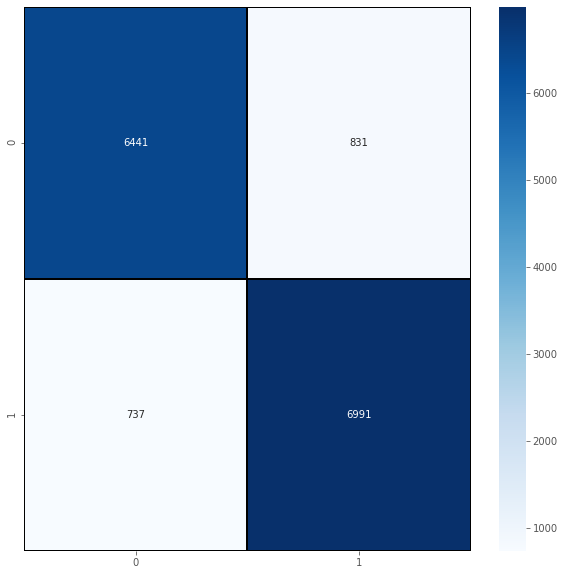

In [12]:
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [10]:
%%time
save_classifier = open("ScoreVecClassifier.pickle","wb")
pickle.dump(scoreVecClassifier, save_classifier)
save_classifier.close()

pickl = {
    'vectorizer': vectorizer,
    'classifier': scoreVecClassifier,
    'accuracy_dict': accuracy_dictString
}
pickle.dump( pickl, open( 'ScoreVecClassifierCLass1' + ".pickle", "wb" ) )

Wall time: 8.33 s


In [13]:
scoringDF
scoringDF.style.highlight_max(color = 'pink', axis = 0)

,Classifier,Accuracy,Precision,Recall,Fscore,Sensitivity,Specificity,Pos_pred_val,Neg_pred_val
0,ExtraTreesClassifier,0.879933,0.879864,0.879755,0.879806,0.886000,0.874000,0.882000,0.878000
1,BernoulliNB,0.875667,0.876293,0.875014,0.875379,0.896000,0.854000,0.867000,0.886000
2,SVC,0.894867,0.894940,0.894581,0.894726,0.904000,0.885000,0.893000,0.897000
3,LogisticRegression,0.892267,0.892447,0.891895,0.892100,0.904000,0.880000,0.889000,0.896000
4,SGDClassifier,0.893800,0.893876,0.893509,0.893657,0.903000,0.884000,0.892000,0.896000
5,LinearSVC,0.891467,0.891481,0.891224,0.891333,0.899000,0.883000,0.891000,0.892000
6,NuSVC,0.891333,0.891438,0.891014,0.891179,0.902000,0.881000,0.889000,0.894000
7,ScoreVecClassifier,0.895467,0.895543,0.895179,0.895326,0.905000,0.886000,0.894000,0.897000
